In [136]:
import numpy as np
import matplotlib.pyplot as plt
from decimal import *
from scipy import special, optimize

import math

import sys
sys.setrecursionlimit(10000)

D = Decimal


from helpers import memoize

## Izracun $f(x)$ in $g(x)$


### Kaj sm naredu

1. Prvo kot prvo, verjetno je bols zmnozit sele nakonc z 1/3. -> PREVER, mogoce pa ne
2. Poisc f_k z rekurzijo, brez fakultet ker te cist zjebe numericno. To nardis z $f_{k+1} = GOODNOTES$

In [103]:
getcontext().prec = 1000


alpha = D(0.355028053887817239)
beta = D(0.258819403792806798)


In [132]:
# x and sum have to be Decimal dtype
def A_B_i(x, max_sum_steps, min_precision, returnB=False, returnA=False, relativeErr=False):
    getcontext().prec = 100
    x = D(float(x))

    precision = D(10).__pow__(D(-min_precision))

    sum_A_i = D(0)
    sum_B_i = D(0)
    k = D(1)
    # pri k = 0 je 1
    f_k = D(1)
    g_k = D(x)

    sum_A_i, sum_B_i, delta_sum_A_i, delta_sum_B_i = [D(0)]*4

    while k < max_sum_steps:
        delta_sum_A_i = alpha * f_k - beta * g_k
        delta_sum_B_i = D(3).sqrt() * (alpha*f_k + beta*g_k)

        if relativeErr:
            try:
                if D(delta_sum_A_i.__abs__() / sum_A_i).compare(precision) < D(1) and D(delta_sum_B_i.__abs__() / sum_B_i).__abs__().compare(precision) < D(1):
                    break
            except:
                max_sum_steps = D(200)
        else:
            if delta_sum_A_i.__abs__().compare(precision) < D(1) and delta_sum_B_i.__abs__().compare(precision) < D(1):
                break

        sum_A_i += delta_sum_A_i
        sum_B_i += delta_sum_B_i

        f_k *= (x**3 * (D(1) - D(2) / D(3) / k)) / \
            (D(3)*k-D(1)) / (D(3)*k - D(2))
        g_k *= (x**3 * (D(1) - D(1) / D(3) / k)) / \
            (D(3)*k+D(1)) / (D(3)*k - D(1))

        k += D(1)

    # print(k, delta_sum_B_i/sum_B_i)

    if returnB:
        return sum_B_i
    elif returnA:
        return sum_A_i

    return sum_A_i,  sum_B_i, k


A_B_i = np.vectorize(A_B_i)


## Prvotni graf funkcij po taylorju

No handles with labels found to put in legend.


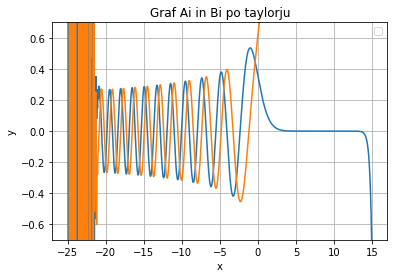

In [105]:
x = np.linspace(-25,15,1000,dtype=Decimal)

# here A_i and B_i are tuples (values, abs_error)
A_i, B_i, k = A_B_i(x, D(100000), D(100))

plt.plot(x, A_i)
plt.plot(x, B_i)



plt.title('Graf Ai in Bi po taylorju')

plt.ylim([-0.7, 0.7])
plt.ylim([-0.7, 0.7])
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.grid()

plt.savefig('grafa_taylor.pdf', bbox_inches='tight')
plt.show()


Zdej pa neki helper funkcij

Pozitivne asimptote

In [106]:
# def L(x, max_steps):
#     sum = 0
#     s = 0
#     while s < max_steps:
#         delta_sum = primitive_u_s(s) / D(x).__pow__(D(s))
#         sum += delta_sum
#         s += 1
#     return sum


def L(x):
    x = D(x)
    sum = D(1)
    L_i = D(1)
    s = 1

    # 1e5 safety mechanism
    while s < 1e5:
        factor = (D(s) - D(5)/D(6)) * (D(1) - 1 / D(6) / D(s)) / D(2) / x

        if factor.__abs__() > D(1):
            # print(s)
            return sum

        L_i *= factor
        sum += L_i
        s += 1

    return D(0)


def A_i_big_x(x):
    ksi = D(2)/D(3) * D(x).__abs__().__pow__(D(1.5))


    Ai = (D(-ksi).exp())/(D(2) * D(math.pi).sqrt()
                        * D(x).__pow__(D(0.25))) * L(-ksi)

    return Ai


def B_i_big_x(x):
    ksi = D(2)/D(3) * D(x).__abs__().__pow__(D(1.5))

    Bi = (D(ksi).exp())/(D(math.pi).sqrt() * D(x).__pow__(D(0.25))) * L(ksi)

    # print(steps, new_delta/new_Bi)
    return Bi


A_i_big_x = np.vectorize(A_i_big_x)
B_i_big_x = np.vectorize(B_i_big_x)


## Negativne asimptote

In [107]:
def min_plus_k(k):
    if k % 2 == 0:
        return 1
    return -1


def multiplicator(number_from, i):
    number_from = D(number_from)
    product = D(1)
    for l in range(i):
        product *= D(number_from-D(l))
    return product



def P(x):
    P_i = D(1)
    result = D(1)
    s = D(0)

    # 1e5 safety mechanism
    while s < 1e6:
        fac = 1
        for i in range(6):
            fac *= D(Decimal(6)*s + Decimal(0.5)+D(i))
            factor = Decimal(-1)*(fac)/(Decimal(54)*Decimal(54)*(Decimal(2)*s + Decimal(2))*(Decimal(2)*s + Decimal(1))*(Decimal(2)*s + Decimal(3)/Decimal(2))*(Decimal(2)*s+Decimal(0.5))*(x**(Decimal(2))))
        if factor.copy_abs() > D(1):
            return result
        P_i *= factor
        result += P_i
        s += D(1)


def Q(x):
    Qi = (D(15)/D(4))/(D(54)*x)
    res = Qi
    s = D(0)

    #safety
    while s < 1e6:
        fac = 1
        for i in range(6):
            fac *= D(Decimal(6)*s + Decimal(0.5)+D(3+i))
            factor = D(-1)*(fac)/(D(54)*D(54)*(D(2)*s + D(3))*(D(
            2)*s + D(2))*(multiplicator(D(2)*s + D(5)/D(2),2))*(x**(D(2))))
        if factor.copy_abs() > D(1):
            return res
        Qi *= factor
        res += Qi
        s += D(1)

### Zdej pa se negativne asimptotske

In [108]:
def Ai_negativni_x(x):
    ksi = D(2)/D(3) * D(x).__abs__().__pow__(D(1.5))

    ksi_reduced = ksi % (D(2*math.pi))
    ksi_reduced = D(ksi_reduced) - D(math.pi / 4)


    Ai = (1)/(D(math.pi).sqrt() * D(-x).__pow__(D(0.25))) * (D(math.sin(ksi_reduced))
                                                                    * Q(ksi) + D(math.cos(ksi_reduced)) * P(ksi))

    return Ai

def Bi_negativni_x(x):
    ksi = D(2)/D(3) * D(x).__abs__().__pow__(D(1.5))

    ksi_reduced = ksi % (D(2*math.pi))
    ksi_reduced = D(ksi_reduced) - D(math.pi / 4)

    Bi = (1)/(D(math.pi).sqrt() * D(-x).__pow__(D(0.25))) * (D(-math.sin(ksi_reduced))
                                                                 * P(ksi) + D(math.cos(ksi_reduced)) * Q(ksi))

    return Bi


Ai_negativni_x = np.vectorize(Ai_negativni_x)
Bi_negativni_x = np.vectorize(Bi_negativni_x)


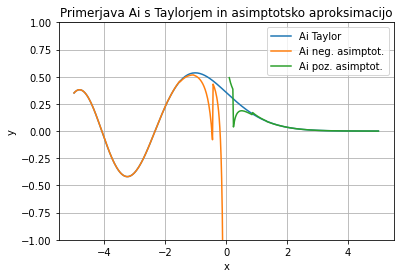

In [110]:
t = np.linspace(-5, 5, 250)

A_i, B_i, k = A_B_i(t, D(100000), D(10))

x = np.linspace(-5, -0.01, 250)

Ai_asimptotika = Ai_negativni_x(x)

z = np.linspace(0.1, 5, 250)
Ai_asimptotika_veliki = A_i_big_x(z)
# Bi_asimptotika, Bi_errors = Bi_negativni_x(t)

plt.plot(t, A_i, label='Ai Taylor')
# plt.plot(t, B_i)
plt.plot(x, Ai_asimptotika, label='Ai neg. asimptot.')
plt.plot(z, Ai_asimptotika_veliki, label='Ai poz. asimptot.')
# plt.plot(t, Bi_asimptotika)


# plt.plot(t, np.abs(B_i - Bi_asimptotika))

plt.title('Primerjava Ai s Taylorjem in asimptotsko aproksimacijo')
plt.ylim([-1, 1])
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.savefig('Ai_taylor_asimptotika.pdf',bbox_inches='tight')
plt.show()


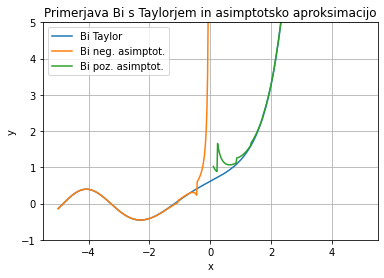

In [111]:
t = np.linspace(-5, 5, 250)

A_i, B_i, k = A_B_i(t, D(100000), D(10))

x = np.linspace(-5, -0.01, 250)

Bi_asimptotika = Bi_negativni_x(x)

z = np.linspace(0.1, 5, 250)
Bi_asimptotika_veliki = B_i_big_x(z)
# Bi_asimptotika, Bi_errors = Bi_negativni_x(t)

plt.plot(t, B_i, label='Bi Taylor')
# plt.plot(t, B_i)
plt.plot(x, Bi_asimptotika, label='Bi neg. asimptot.')
plt.plot(z, Bi_asimptotika_veliki, label='Bi poz. asimptot.')
# plt.plot(t, Bi_asimptotika)


# plt.plot(t, np.abs(B_i - Bi_asimptotika))

plt.title('Primerjava Bi s Taylorjem in asimptotsko aproksimacijo')
plt.ylim([-1, 5])
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.savefig('Bi_taylor_asimptotika.pdf', bbox_inches='tight')
plt.show()


Koncni funkciji

In [133]:
min_x_Bi = -5
max_x_Bi = 8.3


def final_Bi(x):
    x = D(x)
    if x < min_x_Bi:
        return Bi_negativni_x(x)
    if x > max_x_Bi:
        return B_i_big_x(x)

    return A_B_i(x, D(100000), D(15), returnB=True)


# final_Bi = memoize(final_Bi)

min_x_Ai = -10
max_x_Ai = 5.3


def final_Ai(x):
    x = D(x)
    if x < min_x_Ai:
        return Ai_negativni_x(x)
    if x > max_x_Ai:
        return A_i_big_x(x)

    return A_B_i(x, D(10000), D(20), returnA=True)


# final_Ai = memoize(final_Ai)

final_Ai = np.vectorize(final_Ai)
final_Bi = np.vectorize(final_Bi)


# def getVals(x, func):
#     return func(x)[0]


# def getErrs(x, func):
#     return np.abs(func(x)[1])


Narisanje

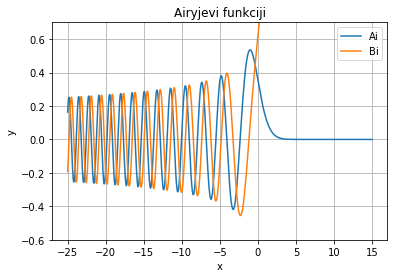

In [113]:
# fig, ax1 = plt.subplots()
x = np.linspace(-25, 15, 1000)
# y = final_Ai(x)
# y = final_Bi(x)

ai_real, aip, bi_real, bip = special.airy(x)
# y_err = np.vectorize(getErrs)(x, final_Ai)
# Bi_asimptotika, Bi_errors = Bi_negativni_x(t)

plt.plot(x, final_Ai(x), label='Ai')
plt.plot(x, final_Bi(x), label='Bi')
# plt.plot(t, B_i)
# plt.plot(t, np.abs(B_i - Bi_asimptotika))

plt.title('Airyjevi funkciji')
plt.ylim([-0.6, 0.7])
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.savefig('airyjevi.pdf', bbox_inches='tight')
plt.show()


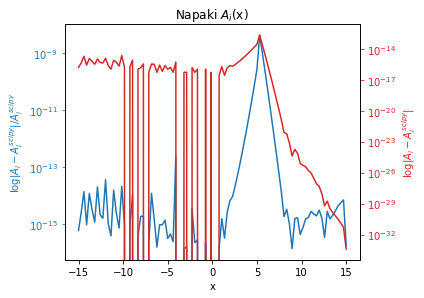

In [134]:
fig, ax1 = plt.subplots()
x = np.linspace(-15, 15, 100)
y = final_Ai(x)

getcontext().prec = 100

ai_real, aip, bi_real, bip = special.airy(x)
# y_err = np.vectorize(getErrs)(x, final_Ai)

y = [np.float64(i) for i in y]
y_err = np.abs(y-ai_real)

# ax1.plot(x, y)
ax1.set_xlabel('x')
# ax1.set_ylim([-0.7, 0.7])

# Make the y-axis label, ticks and tick labels match the line color.
# ax1.set_ylabel('Bi(x)', color='b')
# ax1.tick_params('y', colors='b')

ax1.plot(x, np.abs(y_err/y), 'tab:blue')
ax1.set_ylabel(r'$\log | A_i - A_i^{scipy} |/ A_i^{scipy}$', color='tab:blue')
ax1.tick_params('y', colors='tab:blue')
ax1.set_yscale('log')

ax2 = ax1.twinx()
ax2.plot(x, y_err, 'tab:red')
ax2.set_ylabel(r'$\log | A_i - A_i^{scipy} |$', color='tab:red')
ax2.set_yscale('log')
ax2.tick_params('y', colors='tab:red')

fig.tight_layout()
plt.title('Napaki $A_i$(x)')

plt.savefig('Napake_Ai.pdf', bbox_inches='tight')
plt.show()


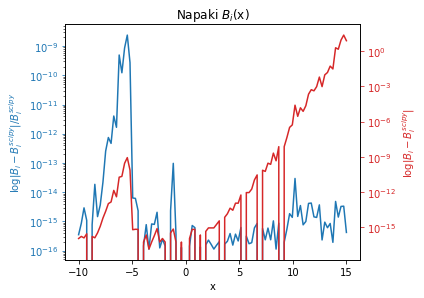

In [135]:
fig, ax1 = plt.subplots()
x = np.linspace(-10, 15, 100)
y = final_Bi(x)

ai_real, aip, bi_real, bip = special.airy(x)
# y_err = np.vectorize(getErrs)(x, final_Ai)

y = [np.float64(i) for i in y]
y_err = np.abs(y-bi_real)

# ax1.plot(x, y)
ax1.set_xlabel('x')
# ax1.set_ylim([-0.7, 0.7])

# Make the y-axis label, ticks and tick labels match the line color.
# ax1.set_ylabel('Bi(x)', color='b')
# ax1.tick_params('y', colors='b')

ax1.plot(x, np.abs(y_err/y), 'tab:blue')
ax1.set_ylabel(r'$\log | B_i - B_i^{scipy} |/ B_i^{scipy}$', color='tab:blue')
ax1.tick_params('y', colors='tab:blue')
ax1.set_yscale('log')

ax2 = ax1.twinx()
ax2.plot(x, y_err, 'tab:red')
ax2.set_ylabel(r'$\log | B_i - B_i^{scipy} |$', color='tab:red')
ax2.set_yscale('log')
ax2.tick_params('y', colors='tab:red')

fig.tight_layout()
plt.title('Napaki $B_i$(x)')

plt.savefig('Napake_Bi.pdf', bbox_inches='tight')

plt.show()


### Nicle

Scipy ma bisekcijo. Sam porab na natancnost. Natancnost je vbistvu sestevek napake.

In [236]:
def getZeros(i, func, step):
    zeros = np.array([])
    x = D(0)
    step = D(step)
    previousVal = 1

    while zeros.__len__() < i:
        val = float(func(x))
        # print(val, previousVal, np.sign(val) != np.sign(previousVal))
        if np.sign(val) != np.sign(previousVal):
            zero = optimize.bisect(func, x + step, x, xtol=1e-10)
            zeros = np.append(zeros, zero)
            previousVal = val
        x -= step

    return zeros

def f_zeros(x):
    x = D(x)
    return x.__abs__()**(D(2)/D(3)) * (D(1) + D(5)/(D(48) * x**D(2)) + D(5)/(D(36)*x**D(4)) + (D(77125)/(D(82944)*x**D(6))) + (D(108056875)/(D(6967296)*x**D(8))))


def Ai_zero(s):
    s = D(s)
    return float(-f_zeros(D(3)*D(math.pi)*(D(4)*D(s)-D(1))/D(8)))


def Bi_zero(s):
    s = D(s)
    return float(-f_zeros(D(3)*D(math.pi)*(D(4)*D(s)-D(3))/D(8)))


Ai_zero = np.vectorize(Ai_zero)
Bi_zero = np.vectorize(Bi_zero)


In [244]:
zeros_i = 40

s = np.arange(1,zeros_i, dtype=Decimal)

Ai_formula = np.sort(Ai_zero(s), -1)
Ai_zeros_numerical = np.sort(getZeros(zeros_i-1, final_Ai, 0.5))

Bi_formula = np.sort(Bi_zero(s), -1)
Bi_zeros_numerical = np.sort(getZeros(zeros_i-1, final_Bi, 0.5))

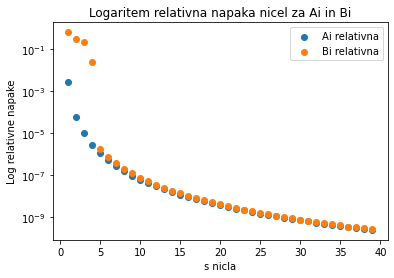

In [245]:
# print(Ai_zeros_numerical, Ai_formula)

diff = np.abs((Ai_formula-Ai_zeros_numerical)/Ai_formula)
diff_abs = np.abs((Ai_formula-Ai_zeros_numerical))
diff_bi = np.abs((Bi_formula-Bi_zeros_numerical)/Bi_formula)
diff_abs_bi = np.abs((Bi_formula-Bi_zeros_numerical))

plt.scatter(s, diff[::-1], label='Ai relativna')
plt.scatter(s, diff_bi[::-1], label='Bi relativna')


plt.yscale('log')
plt.ylabel('Log relativne napake')
plt.xlabel('s nicla')
plt.title(r'Logaritem relativna napaka nicel za Ai in Bi')
plt.legend()

plt.savefig('nicle_relativne.pdf', bbox_inches='tight')

plt.show()



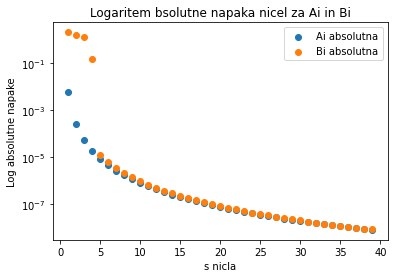

In [246]:
plt.scatter(s, diff_abs[::-1], label='Ai absolutna')
plt.scatter(s, diff_abs_bi[::-1], label='Bi absolutna')

plt.yscale('log')
plt.ylabel('Log absolutne napake')
plt.xlabel('s nicla')
plt.title(r'Logaritem bsolutne napaka nicel za Ai in Bi')
plt.legend()

plt.savefig('nicle_absolutne.pdf', bbox_inches='tight')


plt.show()
